In [1]:
import os as os
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
plt.style.use('seaborn-whitegrid')

plt.rcParams['image.cmap'] = 'blue'

#sns.set_context('notebook',font_scale=2)
sns.set_style("whitegrid")
% matplotlib inline

In [2]:
taxidata = pd.read_csv('data/oneweekfrom20130107.csv', parse_dates=True)

In [3]:
taxidata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265929 entries, 0 to 3265928
Data columns (total 21 columns):
Unnamed: 0            int64
Unnamed: 0.1          int64
medallion             int64
hack_license          int64
vendor_id             object
rate_code             int64
store_and_fwd_flag    object
pickup_datetime       object
dropoff_datetime      object
passenger_count       int64
trip_time_in_secs     int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
payment_type          object
pfare_amount          float64
surcharge             float64
tip_amount            float64
total_amount          float64
dtypes: float64(9), int64(7), object(5)
memory usage: 523.3+ MB


So parsing doe not work, do it manually:

In [4]:
taxidata['pickup_datetime'] =pd.to_datetime(taxidata['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
taxidata['dropoff_datetime'] =pd.to_datetime(taxidata['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
taxidata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,3265929.0,4.235736e+06,942792.637992,2.602772e+06,3.419254e+06,4.235736e+06,5.052218e+06,5.868700e+06
Unnamed: 0.1,3265929.0,4.235737e+06,942792.637992,2.602773e+06,3.419255e+06,4.235737e+06,5.052219e+06,5.868701e+06
medallion,3265929.0,2.013006e+09,3662.811412,2.013000e+09,2.013003e+09,2.013006e+09,2.013009e+09,2.013013e+09
hack_license,3265929.0,2.013014e+09,8375.177708,2.013000e+09,2.013007e+09,2.013014e+09,2.013021e+09,2.013030e+09
rate_code,3265929.0,1.033506e+00,0.349912,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.100000e+02
passenger_count,3265929.0,1.684586e+00,1.360830,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.550000e+02
trip_time_in_secs,3265929.0,6.835442e+02,494.571365,0.000000e+00,3.600000e+02,5.560000e+02,8.800000e+02,1.068000e+04
trip_distance,3265929.0,2.759258e+00,3.260096,0.000000e+00,1.010000e+00,1.700000e+00,3.050000e+00,9.960000e+01
pickup_longitude,3265929.0,-7.262467e+01,10.106291,-2.249272e+03,-7.399187e+01,-7.398157e+01,-7.396671e+01,0.000000e+00
pickup_latitude,3265929.0,4.000632e+01,9.333506,-3.547921e+03,4.073537e+01,4.075310e+01,4.076752e+01,3.310365e+03


In [6]:
taxidata.head()

,Unnamed: 0,Unnamed: 0.1,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,...,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,pfare_amount,surcharge,tip_amount,total_amount
0,2602772,2602773,2013001380,2013001377,VTS,1,NaN,2013-01-07,2013-01-07 00:12:00,2,...,4.24,-73.987915,40.754730,-73.957382,40.782902,CSH,13.5,0.5,0.00,14.50
1,2602773,2602774,2013005435,2013005432,VTS,1,NaN,2013-01-07,2013-01-07 00:04:00,3,...,1.51,-73.984917,40.736370,-73.984917,40.736370,CRD,6.0,0.5,1.30,8.30
2,2602774,2602775,2013002440,2013002437,VTS,1,NaN,2013-01-07,2013-01-07 00:15:00,6,...,4.86,-73.988365,40.720261,-73.920486,40.702522,CSH,16.5,0.5,0.00,17.50
3,2602775,2602776,2013007092,2013007088,VTS,1,NaN,2013-01-07,2013-01-07 00:14:00,1,...,6.33,-73.989822,40.702522,-74.009789,40.737411,CRD,20.0,0.5,4.10,25.10
4,2602776,2602777,2013003235,2013003231,VTS,1,NaN,2013-01-07,2013-01-07 00:06:00,1,...,1.70,-74.005730,40.717567,-74.006401,40.739521,CRD,7.0,0.5,1.88,9.88


In [7]:
payments = taxidata.payment_type.value_counts()

In [8]:
payments/len(taxidata)

CRD    0.528261
CSH    0.468309
NOC    0.002203
DIS    0.000782
UNK    0.000446
Name: payment_type, dtype: float64

# <font color = 'red'> Drop NOC, DIS, UNK? </font color>

# <font color = 'blue'>  So thats the statistic about payments. Remember, there are to tips recorded for cash payment. </font color>

We are not interested in the following features (they do not add any further information):

In [9]:
taxidata = taxidata.drop(['Unnamed: 0', 'Unnamed: 0.1','vendor_id', 
               'rate_code', 'store_and_fwd_flag',  'pfare_amount', 'payment_type', 
               'surcharge'], axis=1)

In [10]:
taxidata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
medallion,3265929.0,2.013006e+09,3662.811412,2.013000e+09,2.013003e+09,2.013006e+09,2.013009e+09,2.013013e+09
hack_license,3265929.0,2.013014e+09,8375.177708,2.013000e+09,2.013007e+09,2.013014e+09,2.013021e+09,2.013030e+09
passenger_count,3265929.0,1.684586e+00,1.360830,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.550000e+02
trip_time_in_secs,3265929.0,6.835442e+02,494.571365,0.000000e+00,3.600000e+02,5.560000e+02,8.800000e+02,1.068000e+04
trip_distance,3265929.0,2.759258e+00,3.260096,0.000000e+00,1.010000e+00,1.700000e+00,3.050000e+00,9.960000e+01
pickup_longitude,3265929.0,-7.262467e+01,10.106291,-2.249272e+03,-7.399187e+01,-7.398157e+01,-7.396671e+01,0.000000e+00
pickup_latitude,3265929.0,4.000632e+01,9.333506,-3.547921e+03,4.073537e+01,4.075310e+01,4.076752e+01,3.310365e+03
dropoff_longitude,3265911.0,-7.257707e+01,10.540788,-2.350956e+03,-7.399115e+01,-7.398001e+01,-7.396381e+01,2.084300e+03
dropoff_latitude,3265911.0,3.997879e+01,8.490421,-3.547921e+03,4.073465e+01,4.075365e+01,4.076839e+01,3.210338e+03
tip_amount,3265929.0,1.269877e+00,2.032800,0.000000e+00,0.000000e+00,9.000000e-01,2.000000e+00,2.000000e+02


# Check for missing and false data:

In [11]:
taxidata.isnull().sum()

medallion             0
hack_license          0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
trip_time_in_secs     0
trip_distance         0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    18
dropoff_latitude     18
tip_amount            0
total_amount          0
dtype: int64

So there is not that much data missing. That's quite surprising, maybe it's wrong.

In [12]:
(taxidata==0).sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           41
trip_time_in_secs       7469
trip_distance          18403
pickup_longitude       59605
pickup_latitude        59102
dropoff_longitude      61733
dropoff_latitude       61229
tip_amount           1584618
total_amount               0
dtype: int64

So we have many zeros in the data. How much percent?

In [13]:
(taxidata==0).sum()/len(taxidata)

medallion            0.000000
hack_license         0.000000
pickup_datetime      0.000000
dropoff_datetime     0.000000
passenger_count      0.000013
trip_time_in_secs    0.002287
trip_distance        0.005635
pickup_longitude     0.018251
pickup_latitude      0.018097
dropoff_longitude    0.018902
dropoff_latitude     0.018748
tip_amount           0.485197
total_amount         0.000000
dtype: float64

# <font color = 'blue' > Most of the zeros are missing data. So flag them as NaN (means also NA) to be consistent! </font color>

In [14]:
taxidata = taxidata.replace(np.float64(0), np.nan);

In [15]:
taxidata.isnull().sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           41
trip_time_in_secs       7469
trip_distance          18403
pickup_longitude       59605
pickup_latitude        59102
dropoff_longitude      61751
dropoff_latitude       61247
tip_amount           1584618
total_amount               0
dtype: int64

Identify the the cases without geo data and remove them from our data to be processed.

In [16]:
anomaly = taxidata.loc[(taxidata['dropoff_longitude'].isnull()) | (taxidata['dropoff_latitude'].isnull()) | 
                       (taxidata['pickup_longitude'].isnull()) | (taxidata['pickup_latitude'].isnull())]
taxidata = taxidata.drop(anomaly.index)

In [17]:
anomaly['flag'] = 'geo_NA'

In [18]:
taxidata.isnull().sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           17
trip_time_in_secs       2144
trip_distance          13098
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
tip_amount           1552688
total_amount               0
dtype: int64

So how many percent of data are left to be processed?

In [19]:
len(taxidata)/(len(taxidata)+len(anomaly))

0.9804744683671935

# <font color = 'blue'> So we only dropped 2% of the data because of missing geo tags. Someone could search the 'anomaly'-data for patterns, e.g. for fraud detection. We are also going to drop all the unrecognized trip_distances because we cannot (exactly) generate them (an approximation would be possible). Missing values in trip_time_in_secs can be generated. </font color>

In [20]:
#taxidata.loc[(taxidata['trip_distance'].isnull())]
#print(len(anomaly))
anomaly = anomaly.append(taxidata.loc[(taxidata['trip_distance'].isnull())])
#anomaly.tail()
#taxidata = taxidata.drop(anomaly.index)

In [21]:
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,flag,hack_license,medallion,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time_in_secs
3265501,2013-01-13 23:57:33,40.710545,-74.013443,NaN,2013007949,2013007953,2.0,2013-01-13 23:57:17,40.710499,-74.013458,14.32,71.62,NaN,16.0
3265507,2013-01-13 23:57:22,40.705894,-74.006660,NaN,2013002046,2013002049,1.0,2013-01-13 23:57:20,40.705894,-74.006660,7.50,60.00,NaN,2.0
3265626,2013-01-13 23:58:00,40.719223,-73.987015,NaN,2013030283,2013010476,1.0,2013-01-13 23:58:00,40.719227,-73.987038,13.00,70.30,NaN,NaN
3265655,2013-01-13 23:58:22,40.739307,-73.979889,NaN,2013007009,2013010587,1.0,2013-01-13 23:58:03,40.739300,-73.979881,NaN,3.50,NaN,18.0
3265707,2013-01-14 00:01:27,40.747421,-73.990158,NaN,2013028238,2013008346,1.0,2013-01-13 23:58:35,40.747421,-73.990158,NaN,90.00,NaN,172.0


In [22]:
#anomaly.iloc[taxidata.loc[(taxidata['trip_distance'].isnull().index]['flag'] = 'trip_dist_NA'
# Be carefol! Do not work on the view but on the data! There is a difference between [col1, col2] and [col1][col2]!
anomaly.loc[taxidata.loc[(taxidata['trip_distance'].isnull())].index,'flag'] = 'trip_dist_NA'

In [23]:
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,flag,hack_license,medallion,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time_in_secs
3265501,2013-01-13 23:57:33,40.710545,-74.013443,trip_dist_NA,2013007949,2013007953,2.0,2013-01-13 23:57:17,40.710499,-74.013458,14.32,71.62,NaN,16.0
3265507,2013-01-13 23:57:22,40.705894,-74.006660,trip_dist_NA,2013002046,2013002049,1.0,2013-01-13 23:57:20,40.705894,-74.006660,7.50,60.00,NaN,2.0
3265626,2013-01-13 23:58:00,40.719223,-73.987015,trip_dist_NA,2013030283,2013010476,1.0,2013-01-13 23:58:00,40.719227,-73.987038,13.00,70.30,NaN,NaN
3265655,2013-01-13 23:58:22,40.739307,-73.979889,trip_dist_NA,2013007009,2013010587,1.0,2013-01-13 23:58:03,40.739300,-73.979881,NaN,3.50,NaN,18.0
3265707,2013-01-14 00:01:27,40.747421,-73.990158,trip_dist_NA,2013028238,2013008346,1.0,2013-01-13 23:58:35,40.747421,-73.990158,NaN,90.00,NaN,172.0


In [24]:
taxidata = taxidata.drop(anomaly.index, errors='ignore') # ignore uncontained labels

In [25]:
taxidata.isnull().sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           15
trip_time_in_secs       1095
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
tip_amount           1543912
total_amount               0
dtype: int64

In [26]:
1-len(taxidata)/(len(taxidata)+len(anomaly))

0.023536029105348022

We already know that there is some data missing in trip_time_in_secs. Therefore we generate it through the information we have from the pickup- and dropoff-datetimes.

In [27]:
taxidata.loc[taxidata.trip_time_in_secs.isnull()].info()
taxidata.loc[taxidata.trip_time_in_secs.isnull()].iloc[995:1015]
#taxidata.loc[taxidata.trip_time_in_secs.isnull(), 'dropoff_datetime']# - \
#taxidata.loc[taxidata.trip_time_in_secs.isnull(),'pickup_datetime']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 3204 to 3263562
Data columns (total 13 columns):
medallion            1095 non-null int64
hack_license         1095 non-null int64
pickup_datetime      1095 non-null datetime64[ns]
dropoff_datetime     1095 non-null datetime64[ns]
passenger_count      1095 non-null float64
trip_time_in_secs    0 non-null float64
trip_distance        1095 non-null float64
pickup_longitude     1095 non-null float64
pickup_latitude      1095 non-null float64
dropoff_longitude    1095 non-null float64
dropoff_latitude     1095 non-null float64
tip_amount           147 non-null float64
total_amount         1095 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(2)
memory usage: 119.8 KB


,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,total_amount
2944954,2013002518,2013002515,2013-01-13 05:48:00,2013-01-13 05:48:00,5.0,NaN,0.19,-73.949493,40.640923,-73.950829,40.640842,NaN,3.5
2945287,2013001434,2013001431,2013-01-13 05:53:00,2013-01-13 05:53:00,2.0,NaN,0.12,-73.965797,40.650429,-73.965141,40.650688,8.0,48.5
2946076,2013008845,2013028305,2013-01-13 06:04:00,2013-01-13 06:04:00,1.0,NaN,0.01,-73.973885,40.794327,-73.973907,40.794312,NaN,3.0
2946265,2013003719,2013003715,2013-01-13 06:07:00,2013-01-13 06:07:00,1.0,NaN,0.31,-73.972237,40.786392,-73.972733,40.785816,NaN,3.5
2947830,2013002947,2013012377,2013-01-13 06:31:00,2013-01-13 06:31:00,6.0,NaN,0.41,-73.991348,40.755516,-73.989021,40.758438,NaN,4.0
2948743,2013002188,2013001539,2013-01-13 06:43:00,2013-01-13 06:43:00,5.0,NaN,0.34,-73.981628,40.752281,-73.986534,40.749607,NaN,3.5
2949566,2013000141,2013000141,2013-01-13 06:54:00,2013-01-13 06:54:00,5.0,NaN,0.02,-73.966682,40.799030,-73.966682,40.799030,NaN,3.0
2949701,2013000572,2013012260,2013-01-13 06:56:00,2013-01-13 06:56:00,1.0,NaN,0.13,-74.006813,40.735771,-74.007370,40.735626,NaN,3.0
2949782,2013011102,2013014679,2013-01-13 06:57:00,2013-01-13 06:57:00,1.0,NaN,1.95,-73.975067,40.757706,-74.000092,40.758617,NaN,9.5
2950729,2013006669,2013014147,2013-01-13 07:09:00,2013-01-13 07:09:00,1.0,NaN,0.05,-73.973656,40.738422,-73.973656,40.738422,NaN,5.5


We can see via a quick inspection, that the datetimes in pickup and dropoff are equal. So we cannot reproduce the trip times. We can also see that there are trips where the geodata are the same for pickup and dropoff. Is there some fraud going on here? If all that is payed with cash, it could be money laundering. 

# <font color = 'red'> Where trip_time = 0, pickup_geo needs to be the same as dropoff_geo. Is this fulfilled? </font color>

# <font color = 'blue'> This are strange data. Pickup and dropoff are sometimes the same in geodata and in datetime. Furthermore, the total amount shows high variation in the same distance (e.g. 0.01 miles for 57.3\$ and 3.0\$). We'll put all of that in the anomaly-data. </font color>

In [28]:
(taxidata.loc[taxidata.trip_time_in_secs.isnull(), 'dropoff_datetime']- \
taxidata.loc[taxidata.trip_time_in_secs.isnull(),'pickup_datetime']).sum()

Timedelta('0 days 00:24:03')

In [29]:
anomaly = anomaly.append(taxidata.loc[(taxidata['trip_time_in_secs'].isnull())])
anomaly.loc[taxidata.loc[(taxidata['trip_time_in_secs'].isnull())].index,'flag'] = 'trip_time_NA'
taxidata = taxidata.drop(anomaly.index, errors='ignore') # ignore uncontained labels / indices

In [30]:
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,flag,hack_license,medallion,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time_in_secs
3247520,2013-01-13 22:40:00,40.736046,-73.989349,trip_time_NA,2013020834,2013005240,6.0,2013-01-13 22:40:00,40.738895,-73.987343,NaN,4.5,0.44,NaN
3258283,2013-01-13 23:22:00,40.772289,-73.956009,trip_time_NA,2013009929,2013009929,5.0,2013-01-13 23:22:00,40.772316,-73.955986,NaN,3.5,0.08,NaN
3260133,2013-01-13 23:30:00,40.648781,-73.785507,trip_time_NA,2013001165,2013001168,1.0,2013-01-13 23:30:00,40.648514,-73.785347,NaN,3.5,0.04,NaN
3261028,2013-01-13 23:34:00,40.645409,-73.776665,trip_time_NA,2013005170,2013005173,2.0,2013-01-13 23:34:00,40.645367,-73.776627,NaN,3.5,0.05,NaN
3263562,2013-01-13 23:47:00,40.763348,-73.928284,trip_time_NA,2013016853,2013005133,1.0,2013-01-13 23:47:00,40.763344,-73.928284,NaN,3.5,0.04,NaN


In [31]:
1-len(taxidata)/(len(taxidata)+len(anomaly))

0.02387130889863187

# <font color = 'blue'> So all in all, we dropped about 2.4% of the data. </font color>

In [32]:
taxidata.isnull().sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           15
trip_time_in_secs          0
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
tip_amount           1542964
total_amount               0
dtype: int64

We can deal with that. External investigation of the anomaly is recommended.

# Start validating the non-anomaly data: Valid trip_time, valid distance?

In [33]:
taxidata['diff_calc_rec_time'] = taxidata.dropoff_datetime - taxidata.pickup_datetime - \
    pd.to_timedelta(taxidata['trip_time_in_secs'], unit='s')

In [34]:
taxidata.trip_time_in_secs.describe()

count    3.187967e+06
mean     6.862127e+02
std      4.913252e+02
min      1.000000e+00
25%      3.600000e+02
50%      5.600000e+02
75%      8.830000e+02
max      1.068000e+04
Name: trip_time_in_secs, dtype: float64

Okay, even here we have unreasonable trip_times. We'll identify those trips later via avg_velocity.

In [35]:
taxidata.diff_calc_rec_time.describe()

count                   3187967
mean     0 days 00:00:01.708074
std      0 days 00:11:30.114537
min           -1 days +23:20:13
25%             0 days 00:00:00
50%             0 days 00:00:00
75%             0 days 00:00:01
max            14 days 00:00:34
Name: diff_calc_rec_time, dtype: object

In [36]:
taxidata.trip_time_in_secs.quantile([.0001,.01, .95, .99, .9999])

0.0001       4.0000
0.0100     104.0000
0.9500    1605.0000
0.9900    2465.0000
0.9999    6000.2034
Name: trip_time_in_secs, dtype: float64

# <font color = 'red'> An ECDF with logarithmic scale might be suitable right here for identifying unreasonably small trip_times. Have a look at the average amount per time! </font color>

In [37]:
taxidata['avg_amount_per_minute'] = taxidata.total_amount / (taxidata.trip_time_in_secs / 60.0)

Min:0.0189553496209
Max:6000.0


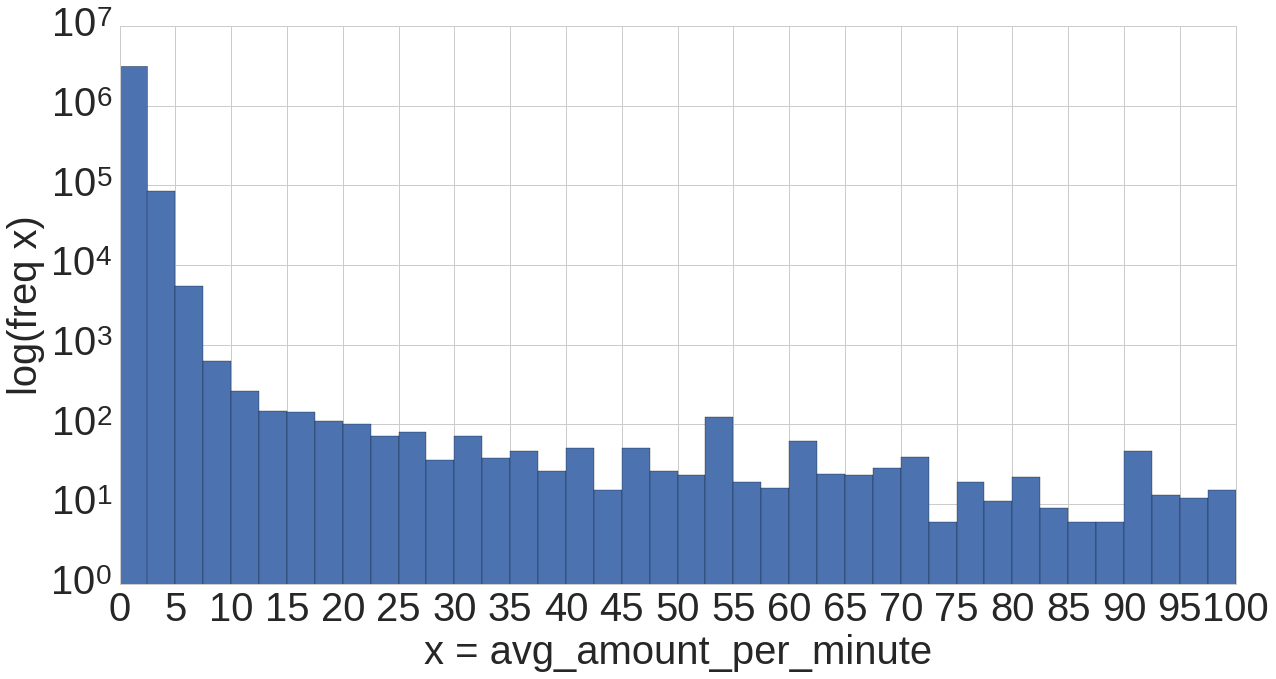

In [38]:
h = taxidata.avg_amount_per_minute
plt.figure(figsize=(20,10))
plt.hist(h, normed=False, stacked=True, bins=40, range=[0 , 100], )
    #, histtype='stepfilled')
plt.yscale('log')
plt.ylabel('log(freq x)', fontsize=40)
plt.xlabel('x = avg_amount_per_minute', fontsize=40)
print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [39]:
taxidata.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,total_amount,diff_calc_rec_time,avg_amount_per_minute
0,2013001380,2013001377,2013-01-07,2013-01-07 00:12:00,2.0,720.0,4.24,-73.987915,40.754730,-73.957382,40.782902,NaN,14.50,0 days,1.208333
1,2013005435,2013005432,2013-01-07,2013-01-07 00:04:00,3.0,240.0,1.51,-73.984917,40.736370,-73.984917,40.736370,1.30,8.30,0 days,2.075000
2,2013002440,2013002437,2013-01-07,2013-01-07 00:15:00,6.0,900.0,4.86,-73.988365,40.720261,-73.920486,40.702522,NaN,17.50,0 days,1.166667
3,2013007092,2013007088,2013-01-07,2013-01-07 00:14:00,1.0,840.0,6.33,-73.989822,40.702522,-74.009789,40.737411,4.10,25.10,0 days,1.792857
4,2013003235,2013003231,2013-01-07,2013-01-07 00:06:00,1.0,360.0,1.70,-74.005730,40.717567,-74.006401,40.739521,1.88,9.88,0 days,1.646667


In [40]:
taxidata.avg_amount_per_minute.describe()

count    3.187967e+06
mean     1.417456e+00
std      1.000623e+01
min      1.895535e-02
25%      1.003226e+00
50%      1.203209e+00
75%      1.497619e+00
max      6.000000e+03
Name: avg_amount_per_minute, dtype: float64

In [41]:
taxidata.avg_amount_per_minute.quantile([.0001,.01, .95, .99, .995])

0.0001    0.074964
0.0100    0.714286
0.9500    2.186916
0.9900    3.250000
0.9950    4.000000
Name: avg_amount_per_minute, dtype: float64

In [42]:
anomaly = anomaly.append(taxidata.loc[(taxidata['avg_amount_per_minute'] > 2.5) | 
                                      (taxidata['avg_amount_per_minute'] < 0.5)])
#anomaly.loc[
taxidata.loc[(taxidata['avg_amount_per_minute'] > 2.5).index,'flag'] = 'too fast'
taxidata.loc[(taxidata['avg_amount_per_minute'] < 0.5).index,'flag'] = 'too slow'
taxidata = taxidata.drop(anomaly.index, errors='ignore') # ignore uncontained labels / indices
print(1-len(taxidata)/(len(taxidata)+len(anomaly)))

0.05113154633796391


In [43]:
taxidata.tail()

,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,total_amount,diff_calc_rec_time,avg_amount_per_minute,flag
3265924,2013002806,2013002803,2013-01-13 23:59:57,2013-01-14 00:03:57,1.0,240.0,1.3,-73.929535,40.699783,-73.944649,40.707939,1.75,8.75,00:00:00,2.187500,too slow
3265925,2013007209,2013011285,2013-01-13 23:59:58,2013-01-14 00:08:24,1.0,506.0,2.4,-73.980927,40.761757,-73.950859,40.769905,2.10,12.60,00:00:00,1.494071,too slow
3265926,2013009171,2013004728,2013-01-13 23:59:58,2013-01-14 00:03:36,1.0,217.0,0.9,-74.009911,40.715023,-74.017647,40.708046,1.00,7.00,00:00:01,1.935484,too slow
3265927,2013003210,2013004960,2013-01-13 23:59:59,2013-01-14 00:06:26,1.0,387.0,2.1,-73.977791,40.751560,-73.978104,40.730843,1.90,11.40,00:00:00,1.767442,too slow
3265928,2013010217,2013010222,2013-01-13 23:59:59,2013-01-14 00:07:41,3.0,461.0,1.4,-73.983177,40.744747,-74.003777,40.743305,1.80,10.80,00:00:01,1.405640,too slow


In [44]:
#anomaly.loc[(anomaly['pickup_datetime'] == anomaly['dropoff_datetime'])].tail(15)
#anomaly.loc[3265892]
anomaly.loc[3212817]

avg_amount_per_minute                    NaN
diff_calc_rec_time                       NaT
dropoff_datetime         2013-01-13 20:36:00
dropoff_latitude                     40.7256
dropoff_longitude                   -74.0052
flag                            trip_time_NA
hack_license                      2013029479
medallion                         2013003292
passenger_count                            1
pickup_datetime          2013-01-13 20:36:00
pickup_latitude                      40.7257
pickup_longitude                    -74.0057
tip_amount                               NaN
total_amount                            52.5
trip_distance                           0.05
trip_time_in_secs                        NaN
Name: 3212817, dtype: object

# <font color = 'red' > Drop even more columns (e.g. tip)? </font color>

In [45]:
taxidata.avg_amount_per_minute.describe()

count    3.098937e+06
mean     1.269694e+00
std      3.593290e-01
min      5.000000e-01
25%      1.000000e+00
50%      1.194444e+00
75%      1.460674e+00
max      2.500000e+00
Name: avg_amount_per_minute, dtype: float64

In [46]:
taxidata.pickup_latitude.describe()

count    3.098937e+06
mean     4.074871e+01
std      4.663948e+00
min     -3.181078e+03
25%      4.073686e+01
50%      4.075374e+01
75%      4.076781e+01
max      3.210345e+03
Name: pickup_latitude, dtype: float64

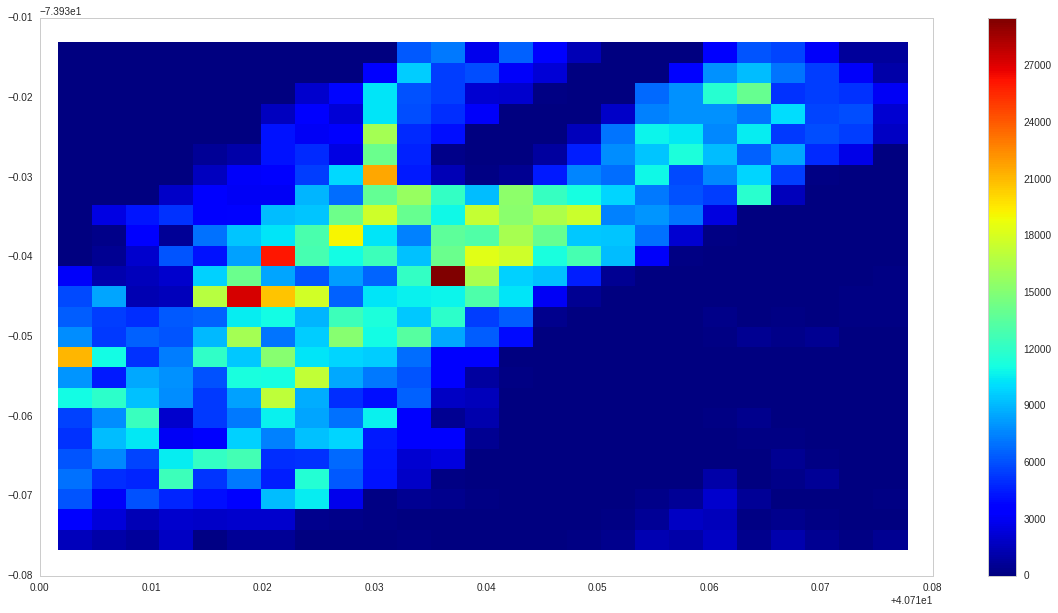

In [47]:
x = taxidata.pickup_latitude
y = taxidata.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=25, range=[ [x.quantile(.05), x.quantile(.95)], 
        [y.quantile(.05), y.quantile(.95)]], normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

In [48]:
type(H)

numpy.ndarray

In [49]:
print(H.shape)
print(H.size)
print(H.max())

(25, 25)
625
29547.0


In [50]:
print(xedges.shape)
xedges[0]

(26,)


40.711646999999999

In [51]:
print(xedges)
print(yedges)

[ 40.711647    40.71468992  40.71773284  40.72077576  40.72381868
  40.7268616   40.72990452  40.73294744  40.73599036  40.73903328
  40.7420762   40.74511912  40.74816204  40.75120496  40.75424788
  40.7572908   40.76033372  40.76337664  40.76641956  40.76946248
  40.7725054   40.77554832  40.77859124  40.78163416  40.78467708  40.78772   ]
[-74.006699   -74.00415444 -74.00160988 -73.99906532 -73.99652076
 -73.9939762  -73.99143164 -73.98888708 -73.98634252 -73.98379796
 -73.9812534  -73.97870884 -73.97616428 -73.97361972 -73.97107516
 -73.9685306  -73.96598604 -73.96344148 -73.96089692 -73.95835236
 -73.9558078  -73.95326324 -73.95071868 -73.94817412 -73.94562956
 -73.943085  ]


In [52]:
from geopy.distance import vincenty
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(vincenty(newport_ri, cleveland_oh).kilometers)
#538.3904451566326

866.4554329011002


In [53]:
print('Current bin width:')
print(vincenty((xedges[0], yedges[0]), (xedges[1], yedges[1])).meters)

Current bin width:
400.51765062952745


In [54]:
distances = (-1)*np.ones(len(xedges)-1)
for x in range(0,len(xedges)-1, 1):
    distances[x] = vincenty((xedges[x], yedges[x]), (xedges[x+1], yedges[x+1])).meters

In [55]:
print('Sizes of all bins in meters:')
distances

Sizes of all bins in meters:


array([ 400.51765063,  400.51254643,  400.50744208,  400.50233758,
        400.49723294,  400.49212813,  400.48702319,  400.48191809,
        400.47681284,  400.47170744,  400.46660189,  400.46149619,
        400.45639034,  400.45128435,  400.4461782 ,  400.4410719 ,
        400.43596546,  400.43085886,  400.42575212,  400.42064522,
        400.41553818,  400.41043098,  400.40532364,  400.40021615,
        400.39510851])

In [56]:
print(str(max(taxidata.pickup_latitude)) +','+ str(max(taxidata.pickup_longitude)))
print(str(max(taxidata.dropoff_latitude)) +','+ str(max(taxidata.dropoff_longitude)))

3210.3447,-0.00031999999
1727.0167,2084.3


# Only look at trips in a given bounding box


In [57]:
jfk_geodata = (40.641547, -73.778118)
ridgefield_geodata = (40.856406, -74.020642)
taxidata_in_box = taxidata.loc[(taxidata['dropoff_latitude'] > jfk_geodata[0]) & 
                       (taxidata['dropoff_longitude'] < jfk_geodata[1]) &
                       (taxidata['dropoff_latitude'] < ridgefield_geodata[0]) & 
                       (taxidata['dropoff_longitude'] > ridgefield_geodata[1]) & 
                       (taxidata['pickup_latitude'] > jfk_geodata[0]) & 
                       (taxidata['pickup_longitude'] < jfk_geodata[1]) &
                       (taxidata['pickup_latitude'] < ridgefield_geodata[0]) & 
                       (taxidata['pickup_longitude'] > ridgefield_geodata[1])         
                       ]
# taxidata = taxidata.drop(anomaly.index)

<font color = 'red'> Be careful! They use negative (lat, long), not East/West! </font color>

In [58]:
taxidata_in_box.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,total_amount,diff_calc_rec_time,avg_amount_per_minute,flag
0,2013001380,2013001377,2013-01-07,2013-01-07 00:12:00,2.0,720.0,4.24,-73.987915,40.754730,-73.957382,40.782902,NaN,14.50,0 days,1.208333,too slow
1,2013005435,2013005432,2013-01-07,2013-01-07 00:04:00,3.0,240.0,1.51,-73.984917,40.736370,-73.984917,40.736370,1.30,8.30,0 days,2.075000,too slow
2,2013002440,2013002437,2013-01-07,2013-01-07 00:15:00,6.0,900.0,4.86,-73.988365,40.720261,-73.920486,40.702522,NaN,17.50,0 days,1.166667,too slow
3,2013007092,2013007088,2013-01-07,2013-01-07 00:14:00,1.0,840.0,6.33,-73.989822,40.702522,-74.009789,40.737411,4.10,25.10,0 days,1.792857,too slow
4,2013003235,2013003231,2013-01-07,2013-01-07 00:06:00,1.0,360.0,1.70,-74.005730,40.717567,-74.006401,40.739521,1.88,9.88,0 days,1.646667,too slow


In [59]:
jfk_geodata < ridgefield_geodata
len(taxidata_in_box)/len(taxidata)

0.986403402198883

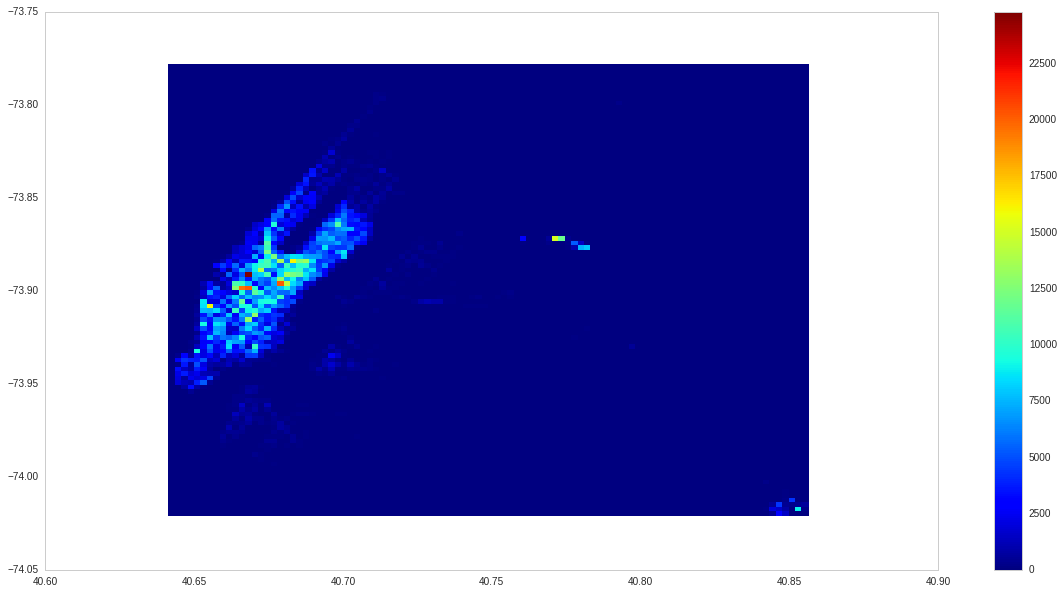

In [60]:
x = taxidata_in_box.pickup_latitude
y = taxidata_in_box.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=100, normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

In [61]:
print(H.shape)
print(H.size)
print(H.max())
print(xedges.shape)
print(xedges)
print(yedges)

distances = (-1)*np.ones(len(xedges)-1)
for x in range(0,len(xedges)-1, 1):
    distances[x] = vincenty((xedges[x], yedges[x]), (xedges[x+1], yedges[x+1])).meters
    
print('Sizes of all bins in meters:')
distances

(100, 100)
10000
24789.0
(101,)
[ 40.641548    40.64369625  40.6458445   40.64799275  40.650141
  40.65228925  40.6544375   40.65658575  40.658734    40.66088225
  40.6630305   40.66517875  40.667327    40.66947525  40.6716235
  40.67377175  40.67592     40.67806825  40.6802165   40.68236475
  40.684513    40.68666125  40.6888095   40.69095775  40.693106
  40.69525425  40.6974025   40.69955075  40.701699    40.70384725
  40.7059955   40.70814375  40.710292    40.71244025  40.7145885
  40.71673675  40.718885    40.72103325  40.7231815   40.72532975
  40.727478    40.72962625  40.7317745   40.73392275  40.736071
  40.73821925  40.7403675   40.74251575  40.744664    40.74681225
  40.7489605   40.75110875  40.753257    40.75540525  40.7575535
  40.75970175  40.76185     40.76399825  40.7661465   40.76829475
  40.770443    40.77259125  40.7747395   40.77688775  40.779036
  40.78118425  40.7833325   40.78548075  40.787629    40.78977725
  40.7919255   40.79407375  40.796222    40.79837025  4

array([ 314.6164374 ,  314.61221738,  314.60799726,  314.60377702,
        314.59955668,  314.59533623,  314.59111567,  314.58689501,
        314.58267424,  314.57845336,  314.57423238,  314.57001128,
        314.56579008,  314.56156878,  314.55734737,  314.55312585,
        314.54890422,  314.54468249,  314.54046065,  314.5362387 ,
        314.53201665,  314.52779449,  314.52357222,  314.51934985,
        314.51512736,  314.51090478,  314.50668208,  314.50245928,
        314.49823638,  314.49401336,  314.48979024,  314.48556701,
        314.48134368,  314.47712024,  314.47289669,  314.46867304,
        314.46444928,  314.46022541,  314.45600144,  314.45177736,
        314.44755318,  314.44332888,  314.43910448,  314.43487998,
        314.43065537,  314.42643065,  314.42220583,  314.4179809 ,
        314.41375586,  314.40953072,  314.40530547,  314.40108011,
        314.39685465,  314.39262908,  314.38840341,  314.38417763,
        314.37995175,  314.37572575,  314.37149966,  314.36727

In [62]:
(H==0).sum()/H.size

0.55220000000000002

# So we know that 55% of the bins have 0 pickups in it.

## Let's take a first look at the distribution if the target variable which we want to estimate:

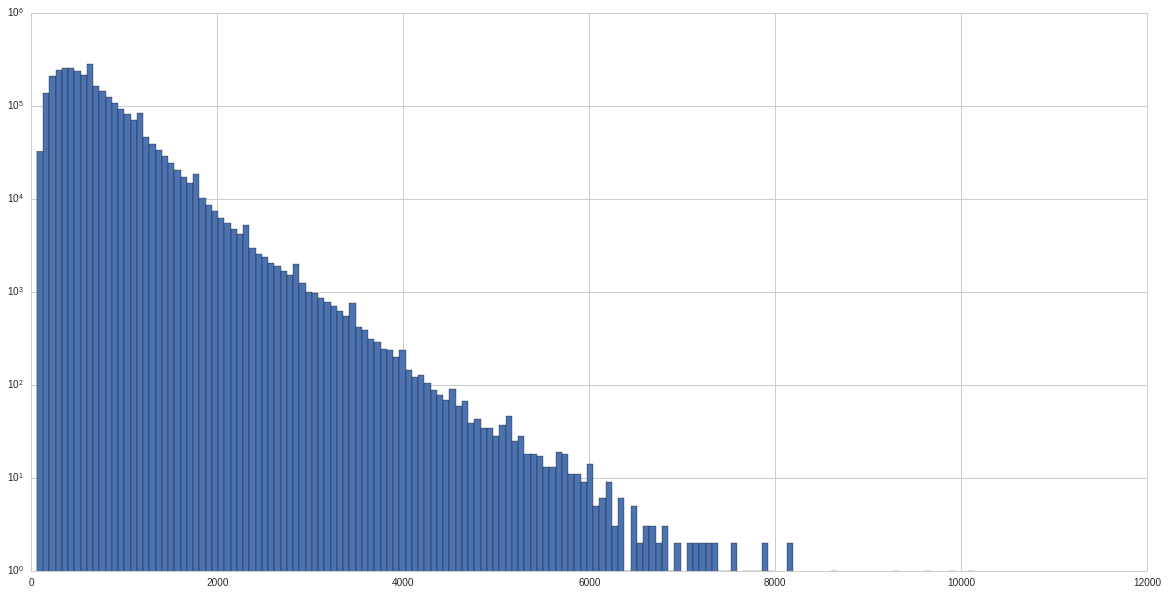

In [63]:
h = taxidata_in_box.trip_time_in_secs
plt.figure(figsize=(20,10))
plt.hist(h, normed=False,  bins=150)
    #, histtype='stepfilled')
plt.yscale('log')
#plt.ylabel('log(freq x)', fontsize=40)
#plt.xlabel('x = avg_amount_per_minute', fontsize=40)
#print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
#plt.yticks(fontsize=40)
#plt.xticks(fontsize=40)
#plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [64]:
taxidata_in_box.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,total_amount,diff_calc_rec_time,avg_amount_per_minute,flag
0,2013001380,2013001377,2013-01-07,2013-01-07 00:12:00,2.0,720.0,4.24,-73.987915,40.754730,-73.957382,40.782902,NaN,14.50,0 days,1.208333,too slow
1,2013005435,2013005432,2013-01-07,2013-01-07 00:04:00,3.0,240.0,1.51,-73.984917,40.736370,-73.984917,40.736370,1.30,8.30,0 days,2.075000,too slow
2,2013002440,2013002437,2013-01-07,2013-01-07 00:15:00,6.0,900.0,4.86,-73.988365,40.720261,-73.920486,40.702522,NaN,17.50,0 days,1.166667,too slow
3,2013007092,2013007088,2013-01-07,2013-01-07 00:14:00,1.0,840.0,6.33,-73.989822,40.702522,-74.009789,40.737411,4.10,25.10,0 days,1.792857,too slow
4,2013003235,2013003231,2013-01-07,2013-01-07 00:06:00,1.0,360.0,1.70,-74.005730,40.717567,-74.006401,40.739521,1.88,9.88,0 days,1.646667,too slow


In [65]:
#taxidata_in_box['pickup_datetime'].dt.dayofweek
#taxidata_in_box['pickup_datetime'].dt.hourb
#taxidata_in_box['pickup_datetime'].dt.month # year, month, day, hour, minute, second, microsecond, and tzinfo.
#taxidata_in_box['pickup_datetime'].dt.day

# Make a new dataframe with features and targets

In [66]:
taxitime_regression_df = pd.DataFrame([taxidata_in_box['pickup_datetime'].dt.day,
                          taxidata_in_box['pickup_datetime'].dt.dayofweek,
                          taxidata_in_box['pickup_datetime'].dt.hour,
                          taxidata_in_box['pickup_latitude'],
                          taxidata_in_box['pickup_longitude'],
                          taxidata_in_box['dropoff_latitude'],
                          taxidata_in_box['dropoff_longitude'],
                          np.ceil(taxidata_in_box['trip_time_in_secs']/60),
                         ]).T
taxitime_regression_df.columns = ['pickup_datetime_day', 'pickup_datetime_dayofweek', 'pickup_datetime_hour',
                                 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
                                 'trip_time_in_mins']#trip_time_in_secs' 

In [67]:
taxitime_regression_df.tail()

,pickup_datetime_day,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time_in_mins
3265924,13.0,6.0,23.0,40.699783,-73.929535,40.707939,-73.944649,4.0
3265925,13.0,6.0,23.0,40.761757,-73.980927,40.769905,-73.950859,9.0
3265926,13.0,6.0,23.0,40.715023,-74.009911,40.708046,-74.017647,4.0
3265927,13.0,6.0,23.0,40.751560,-73.977791,40.730843,-73.978104,7.0
3265928,13.0,6.0,23.0,40.744747,-73.983177,40.743305,-74.003777,8.0


In [68]:
taxitime_regression_df.head()

,pickup_datetime_day,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time_in_mins
0,7.0,0.0,0.0,40.754730,-73.987915,40.782902,-73.957382,12.0
1,7.0,0.0,0.0,40.736370,-73.984917,40.736370,-73.984917,4.0
2,7.0,0.0,0.0,40.720261,-73.988365,40.702522,-73.920486,15.0
3,7.0,0.0,0.0,40.702522,-73.989822,40.737411,-74.009789,14.0
4,7.0,0.0,0.0,40.717567,-74.005730,40.739521,-74.006401,6.0


In [69]:
taxitime_regression_df.ix[:,0:7].describe()

,pickup_datetime_day,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,3.056802e+06,3.056802e+06,3.056802e+06,3.056802e+06,3.056802e+06,3.056802e+06,3.056802e+06
mean,1.009278e+01,3.092780e+00,1.361234e+01,4.075165e+01,-7.397666e+01,4.075207e+01,-7.397583e+01
std,1.945090e+00,1.945090e+00,6.358685e+00,2.518782e-02,3.032372e-02,2.738352e-02,2.793989e-02
min,7.000000e+00,0.000000e+00,0.000000e+00,4.064155e+01,-7.402062e+01,4.064155e+01,-7.402063e+01
25%,8.000000e+00,1.000000e+00,9.000000e+00,4.073722e+01,-7.399216e+01,4.073673e+01,-7.399136e+01
50%,1.000000e+01,3.000000e+00,1.400000e+01,4.075393e+01,-7.398206e+01,4.075442e+01,-7.398064e+01
75%,1.200000e+01,5.000000e+00,1.900000e+01,4.076787e+01,-7.396847e+01,4.076853e+01,-7.396609e+01
max,1.300000e+01,6.000000e+00,2.300000e+01,4.085637e+01,-7.377812e+01,4.085640e+01,-7.377812e+01


In [70]:
print(taxitime_regression_df.trip_time_in_mins.value_counts())
print(len(taxitime_regression_df.trip_time_in_mins.value_counts()))

6.0      238469
7.0      238439
8.0      228722
5.0      226036
9.0      213368
10.0     194550
4.0      191664
11.0     175234
12.0     155390
13.0     137781
3.0      122004
14.0     121371
15.0     105332
16.0      91973
17.0      80811
18.0      70317
19.0      60063
20.0      52016
21.0      44415
22.0      37603
23.0      32540
2.0       28987
24.0      27787
25.0      23806
26.0      20254
27.0      17536
28.0      15025
29.0      13217
30.0      11251
31.0       9743
          ...  
110.0         3
111.0         3
122.0         2
136.0         2
132.0         2
126.0         2
113.0         2
121.0         2
119.0         2
118.0         2
115.0         2
107.0         2
169.0         1
165.0         1
128.0         1
162.0         1
155.0         1
144.0         1
133.0         1
131.0         1
129.0         1
125.0         1
112.0         1
124.0         1
123.0         1
120.0         1
117.0         1
116.0         1
114.0         1
1.0           1
Name: trip_time_in_mins,

# Split the data into a training dataset and a test dataset. Evaluate the performance of the decision tree on the test data

In [72]:
from sklearn import cross_validation as cv
y = taxitime_regression_df["trip_time_in_mins"]
X = taxitime_regression_df.ix[:,0:7]
X_train, X_test, y_train, y_test = cv.train_test_split(X, y,test_size=0.1,random_state=0) 

In [84]:
print(X_train.shape)
print(X_train.size)
print(X_test.shape)
print(X.shape)
print(X_train.shape[0]+X_test.shape[0])

(2751121, 7)
19257847
(305681, 7)
(3056802, 7)
3056802


In [355]:
import time
t = time.time()

In [85]:
print(__doc__)

# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

#features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude','pickup_datetime']
#print("* features:", features, sep="\n")


regtree = DecisionTreeRegressor(min_samples_split=3, random_state=99, max_depth=10)# try 6,7,8,9,10,...
                                                                                     # random states: 99,
regtree.fit(X_train, y_train)




Automatically created module for IPython interactive environment


DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, presort=False, random_state=99,
           splitter='best')

In [86]:
regtree.score(X_test, y_test)    

0.53243866649957994

In [91]:
y_pred = regtree.predict(X_test)
np.linalg.norm(y_pred-y_test)
diff = (y_pred-y_test)

In [95]:
diff

1534969    -4.129416
503493    -13.129416
815611      1.920513
2302035     0.870584
1466170     0.685658
3149603     1.735274
1187652    -0.500138
1528589   -18.129416
2402406     3.162882
548356     -2.129416
2281821    -5.129416
2492580    -4.749356
1785444     0.912722
649204     -2.771814
2986479     3.735274
1363458    -2.276774
2817780    -1.158350
1266009    -1.129416
2126222   -16.040000
2435884     2.735274
3192607    -2.705418
2368127     0.518805
340172     -4.087278
1723368     1.186408
2073852     4.870584
1585587    -3.129416
1429837    -3.129416
696880      1.255822
3128667     3.735274
2903137     2.723226
             ...    
1655908    -1.969105
2393798     5.691729
1722611     6.870584
2522303     1.735274
1631986    -0.689944
193230     -7.129416
2132464     4.870584
1574262     3.870584
2617815     3.735274
1025320    -3.129416
2253295    -4.229885
2872322    -6.276774
1434263    -4.129416
389254      2.250000
1435817    -0.129416
3155436     0.735274
605516     -0

(array([  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   5.00000000e+00,
          7.00000000e+00,   1.20000000e+01,   1.40000000e+01,
          2.00000000e+01,   3.20000000e+01,   6.10000000e+01,
          7.80000000e+01,   2.14000000e+02,   4.39000000e+02,
          1.15300000e+03,   3.53300000e+03,   8.79700000e+03,
          2.35950000e+04,   6.22590000e+04,   1.20476000e+05,
          7.97720000e+04,   4.58800000e+03,   4.12000000e+02,
          1.04000000e+02,   3.40000000e+01,   1.80000000e+01,
          1.00000000e+01,   1.40000000e+01,   8.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([-99.12941606, -94.86884733, -90.60827859, -86.34770986,
        -82.08714112, -77.82657239, -73.56600365, -69.30543492,
        -65.04486618, -60.78429745, -5

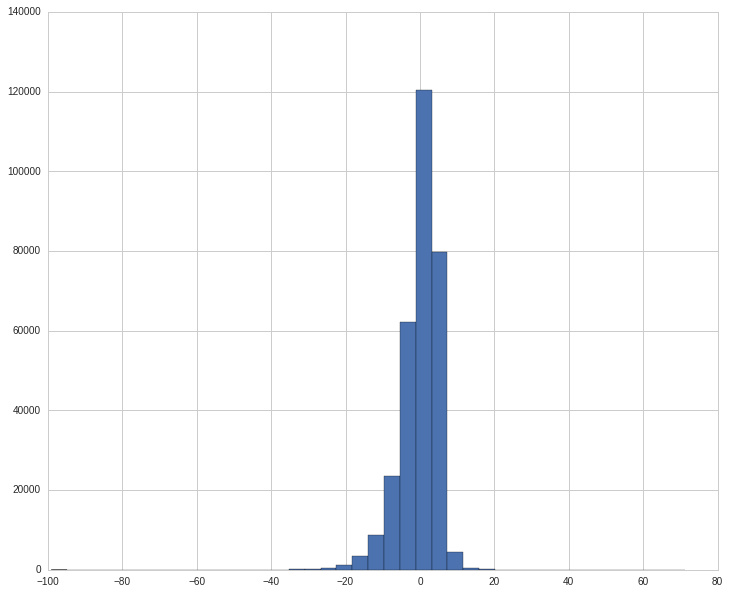

In [111]:
plt.figure(figsize=(12,10))
plt.hist(diff.values, bins=40)

In [112]:
taxitime_regression_df.ix[:,0:7].columns

Index(['pickup_datetime_day', 'pickup_datetime_dayofweek',
       'pickup_datetime_hour', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

In [113]:
from sklearn import tree
tree.export_graphviz(regtree, out_file='figures/tree22min.dot', feature_names=taxitime_regression_df.ix[:,0:7].columns, class_names=taxitime_regression_df.columns[7])    

In [114]:
regtree.tree_.impurity

array([ 57.97882217,  46.15263936,  39.10984041, ...,  21.53718025,
        21.1875    ,  12.91358025])

In [115]:
regtree.tree_.node_count

1917

In [116]:
regtree.tree_.n_outputs

1

In [117]:
regtree.tree_.children_left

array([   1,    2,    3, ..., 1915,   -1,   -1])

In [118]:
regtree.tree_.children_right

array([ 992,  513,  258, ..., 1916,   -1,   -1])

In [119]:
regtree.tree_.threshold

array([-73.88613892, -73.90983582,  40.72278595, ...,  40.85086823,
        -2.        ,  -2.        ])

# Export the tree

In [147]:
from sklearn.externals import joblib
joblib.dump(regtree, 'treelib/regtree_depth_10.pkl') 


['treelib/regtree_depth_10.pkl',
 'treelib/regtree_depth_10.pkl_01.npy',
 'treelib/regtree_depth_10.pkl_02.npy',
 'treelib/regtree_depth_10.pkl_03.npy']

## Read as follows: Split # x results in the children_left[x] and children_right[x], etc. Means: go to the left, and then step by step to the right...

In [120]:
print('cleft: ' + str(regtree.tree_.children_left) + '\n\n', #array of left children
      'cright: ' + str(regtree.tree_.children_right) + '\n\n', #array of right children
    regtree.tree_.feature, '\n\n',#array of nodes splitting feature
    regtree.tree_.threshold, '\n\n', #array of nodes splitting points
    #regtree.tree_.value
     ) #array of nodes values

cleft: [   1    2    3 ..., 1915   -1   -1]

 cright: [ 992  513  258 ..., 1916   -1   -1]

 [ 4  6  5 ...,  3 -2 -2] 

 [-73.88613892 -73.90983582  40.72278595 ...,  40.85086823  -2.          -2.        ] 




numpy.ndarray(regtree.tree_.children_left #array of left children
regtree.tree_.children_right #array of right children
regtree.tree_.feature #array of nodes splitting feature
regtree.tree_.threshold #array of nodes splitting points
regtree.tree_.value #array of nodes values

## Finding leaves:

In [121]:
leaves = regtree.tree_.children_left*regtree.tree_.children_right
for idx, a in enumerate(leaves):
    if a==1:
        x=1# do nothing
    else:
        leaves[idx] = 0
print(leaves)

[0 0 0 ..., 0 1 1]


## Now we've found the leaves

In [122]:
regtree.tree_.compute_feature_importances()

array([ 0.00898548,  0.01205496,  0.04791407,  0.19991551,  0.30251668,
        0.19815623,  0.23045707])

# Seems that the first 3 features are quite irrelevant right now...

In [123]:
splits = regtree.tree_.threshold

[ 11.5   4.5   6.5  12.5  11.5  12.5   8.5   7.5  11.5   7.5   0.5  18.5
   9.5   9.5  10.5   7.5  11.5   7.5   4.5  18.5   7.5  18.5   3.5   4.5
   7.5   5.5  18.5  11.5   0.5  19.5  13.5  12.5   7.5   4.5   6.5  10.5
   2.5   7.5   6.5  19.5  19.5   6.5   4.5  19.5   6.5   4.5   6.5   6.5
   8.5  19.5   7.5  11.5   6.5   6.5  18.5  10.5   7.5  19.5   5.5   7.5
  18.5   6.5  18.5   9.5   7.5   4.5   6.5   4.5  11.5  11.5   6.5   6.5
  19.5   7.5  19.5  11.5   6.5   9.5   4.5  11.5   8.5   9.5  11.5  18.5
  13.5   1.5  10.5   2.5  17.5  16.5  10.5  10.5  19.5   7.5  19.5  12.5
  17.5  14.5  18.5  15.5   7.5   4.5   6.5   6.5  19.5   4.5  11.5  19.5
  13.5   4.5  18.5  13.5   3.5   3.5   9.   13.5   4.5   5.5  14.5   7.5
   8.5   4.5   5.5  14.5   7.5  22.5  18.5  14.5   5.5   4.5   4.5   2.5
   4.5  12.5   4.5   8.5   6.5  13.5  12.5   4.5   3.5  17.5  17.5  16.5
  12.5  17.5  16.5   5.5  15.5  19.5   8.5  11.5   3.5   9.5  12.5   2.5
   5.5  20.5  20.5  10.5  10.5   9.5   9.5  13.5  2

(array([ 11.,  35.,  38.,  27.,  28.,  47.,  17.,  14.,  42.,   6.]),
 array([  0.5,   2.7,   4.9,   7.1,   9.3,  11.5,  13.7,  15.9,  18.1,
         20.3,  22.5]),
 <a list of 10 Patch objects>)

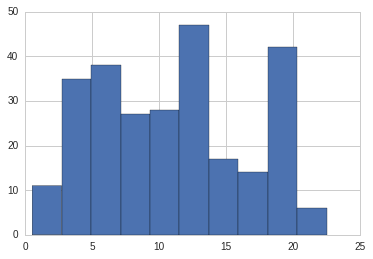

In [124]:
time_splits = splits[(splits>=0) & (splits<=24)]
print(time_splits)
plt.hist(time_splits)

# Where are splits in the hour?

# Filter the splits in longitudinal and latitudinal data

In [125]:
long_splits = splits[(splits>=-75) & (splits<=-70)]
lat_splits = splits[(splits>=40) & (splits<=41)]

# <font color = 'red'> The MSE of each node is stored in the 'impurity'-property. </font color>

In [126]:
#np.multiply(regtree.tree_.value, 1/ regtree.tree_.n_node_samples).size
avg_time_dev = regtree.tree_.impurity.T  * leaves
#avg_time_dev = (np.array(regtree.tree_.value)/np.array(regtree.tree_.n_node_samples)) *np.array(leaves)
avg_time_dev = avg_time_dev[avg_time_dev!=0]

In [131]:
avg_time_dev

array([  1.60884844e+01,   1.62238751e+01,   1.81443210e+01,
         2.40952970e+01,   1.82413458e+01,   1.83414579e+01,
         3.02123458e+01,   2.35496403e+01,   2.52945310e+01,
         1.73437213e+01,   5.21482042e+01,   1.90718512e+01,
         2.19666762e+01,   2.44010974e+02,   4.48571429e+01,
         3.02107512e+01,   4.69600468e+01,   1.91802870e+01,
         4.01872014e+01,   2.05765453e+01,   3.89157981e+01,
         3.93714267e+01,   1.49351645e+01,   1.68343518e+01,
         3.37933819e+01,   3.92693214e+01,   3.74103390e+01,
         1.05213449e+02,   2.73004271e+01,   4.10700059e+01,
         3.74212128e+01,   9.73311654e+01,   2.76910240e+01,
         3.91159655e+01,   1.45494564e+01,   3.92174905e+01,
         1.82549333e+01,   1.97122133e+01,   5.91549742e+01,
         3.10277991e+01,   1.70820506e+01,   2.12142663e+01,
         2.06371243e+01,   2.25178672e+01,   3.26543494e+01,
         2.64850599e+01,   1.25695256e+01,   2.30364797e+01,
         2.09677965e+01,

In [133]:
regtree.tree_.compute_feature_importances()

array([ 0.00898548,  0.01205496,  0.04791407,  0.19991551,  0.30251668,
        0.19815623,  0.23045707])

(array([ 131.,  178.,  154.,  121.,   86.,   50.,   31.,   24.,   20.,
          12.,   10.,    8.,   16.,    2.,    7.,    0.,    4.,    0.,
           2.,    2.,    1.,    1.,    1.,    1.,    4.,    2.,    0.,
           1.,    1.,    1.,    2.,    1.,    0.,    1.,    0.,    1.,
           1.,    1.,    0.,    2.,    0.,    1.,    0.,    0.,    0.,
           0.,    1.,    1.,    1.,    0.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
         450.,  460.,  470.,  480.,  490.,  500.]),
 <a list of 50 Patch objects>)

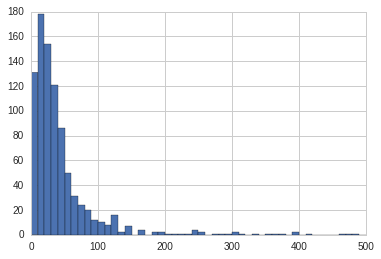

In [134]:
h = avg_time_dev
plt.hist(h.tolist(), bins=50, range=[0, 500])

In [135]:
np.percentile(avg_time_dev, q=[5, 50, 75, 90, 95, 97.5, 99])

array([   3.68098958,   28.67628534,   49.81883599,   97.02519247,
        145.67316935,  284.11006   ,  471.82368152])

In [137]:
#elapsed = time.time() - t

In [138]:
#elapsed

In [139]:
taxitime_regression_df.columns[0:7]

Index(['pickup_datetime_day', 'pickup_datetime_dayofweek',
       'pickup_datetime_hour', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

# <font color = 'blue'> Now we want to visualize the decision tree. To do so, plot the splits in geodata on the map of NYC (together with the heat map) </font color>

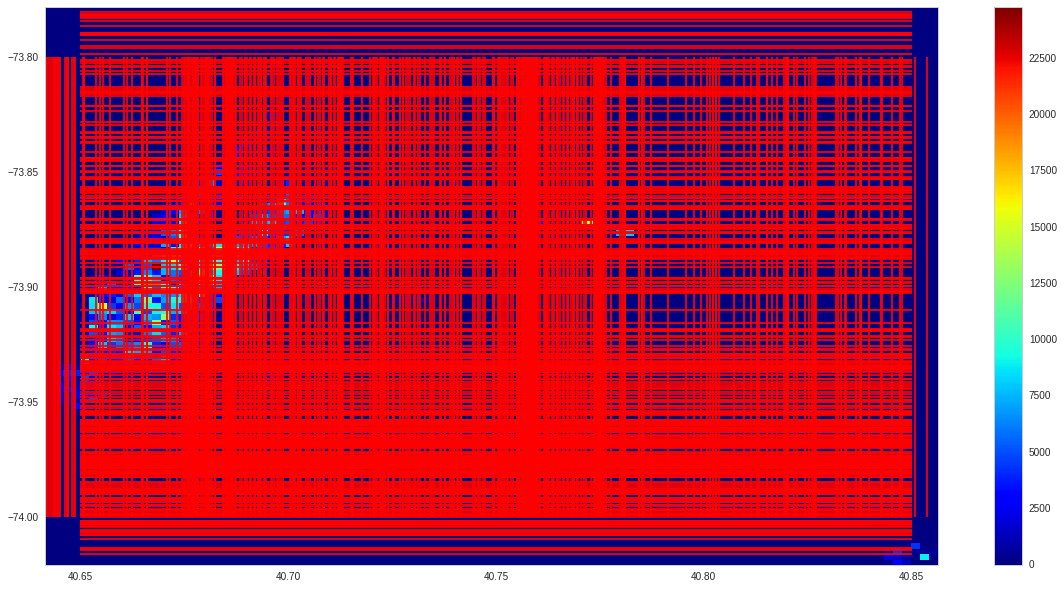

In [140]:
x = taxidata_in_box.pickup_latitude
y = taxidata_in_box.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=100, normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

## Plot the horizontal / vertival lines here via eventplot
plt.hold(True)
plt.eventplot(lat_splits, orientation='horizontal', lineoffsets=-73.9,
          linelengths=0.2, linewidths=None, color = [[1,0,0]],
          linestyles='solid')
plt.eventplot(long_splits, orientation='vertical', lineoffsets=40.75,
          linelengths=.2, linewidths=None, color = [[1,0,0]],
          linestyles='solid')
plt.axis([xedges.min(),xedges.max(),yedges.min(),yedges.max()]) # zoom in
plt.hold(False)

In [141]:
xedges

array([ 40.641548  ,  40.64369625,  40.6458445 ,  40.64799275,
        40.650141  ,  40.65228925,  40.6544375 ,  40.65658575,
        40.658734  ,  40.66088225,  40.6630305 ,  40.66517875,
        40.667327  ,  40.66947525,  40.6716235 ,  40.67377175,
        40.67592   ,  40.67806825,  40.6802165 ,  40.68236475,
        40.684513  ,  40.68666125,  40.6888095 ,  40.69095775,
        40.693106  ,  40.69525425,  40.6974025 ,  40.69955075,
        40.701699  ,  40.70384725,  40.7059955 ,  40.70814375,
        40.710292  ,  40.71244025,  40.7145885 ,  40.71673675,
        40.718885  ,  40.72103325,  40.7231815 ,  40.72532975,
        40.727478  ,  40.72962625,  40.7317745 ,  40.73392275,
        40.736071  ,  40.73821925,  40.7403675 ,  40.74251575,
        40.744664  ,  40.74681225,  40.7489605 ,  40.75110875,
        40.753257  ,  40.75540525,  40.7575535 ,  40.75970175,
        40.76185   ,  40.76399825,  40.7661465 ,  40.76829475,
        40.770443  ,  40.77259125,  40.7747395 ,  40.77

In [142]:
y.min()

-74.020615000000006

In [143]:
taxidata_in_box.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3056802 entries, 0 to 3265928
Data columns (total 16 columns):
medallion                int64
hack_license             int64
pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
passenger_count          float64
trip_time_in_secs        float64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
dropoff_longitude        float64
dropoff_latitude         float64
tip_amount               float64
total_amount             float64
diff_calc_rec_time       timedelta64[ns]
avg_amount_per_minute    float64
flag                     object
dtypes: datetime64[ns](2), float64(10), int64(2), object(1), timedelta64[ns](1)
memory usage: 396.5+ MB


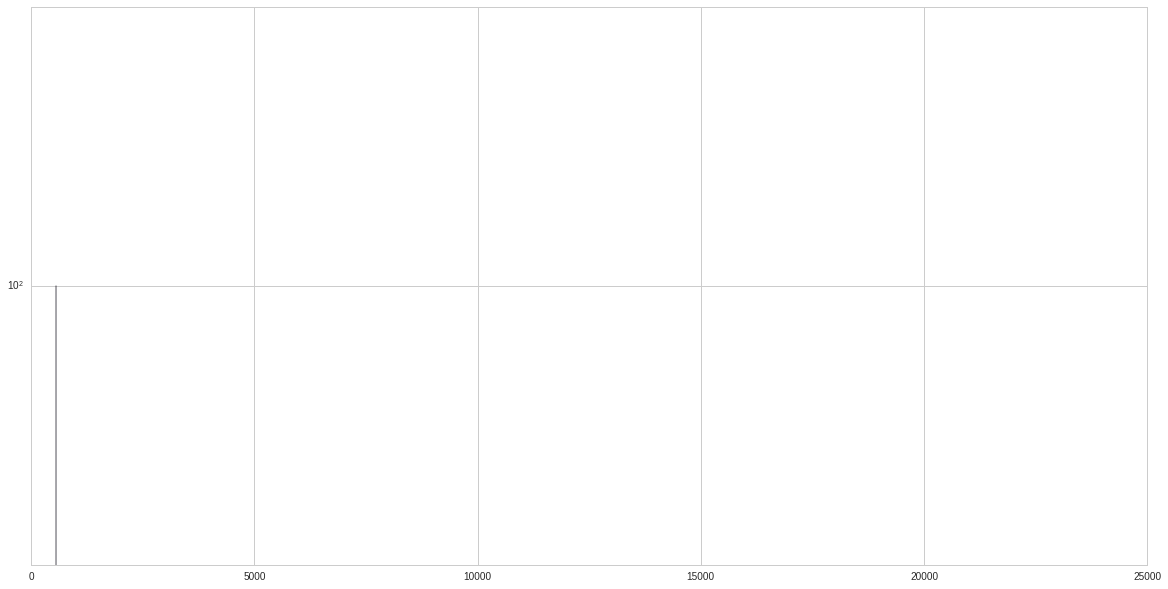

In [144]:
h = H
plt.figure(figsize=(20,10))
plt.hist(h, normed=False,  bins=40)
    #, histtype='stepfilled')
plt.yscale('log')
#plt.ylabel('log(freq x)', fontsize=40)
#plt.xlabel('x = avg_amount_per_minute', fontsize=40)
#print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
#plt.yticks(fontsize=40)
#plt.xticks(fontsize=40)
#plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [106]:
len(xedges)

26

In [102]:
xedges.itemsize

8

In [61]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

crs = None
geometry = [Point(xy) for xy in zip(taxidata.pickup_longitude, taxidata.pickup_latitude)]
geo_df = GeoDataFrame(df, crs=crs, geometry=geometry)

In [64]:
geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3098937 entries, 0 to 3265928
Data columns (total 17 columns):
medallion                int64
hack_license             int64
pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
passenger_count          float64
trip_time_in_secs        float64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
dropoff_longitude        float64
dropoff_latitude         float64
tip_amount               float64
total_amount             float64
diff_calc_rec_time       timedelta64[ns]
avg_amount_per_minute    float64
flag                     object
geometry                 object
dtypes: datetime64[ns](2), float64(10), int64(2), object(2), timedelta64[ns](1)
memory usage: 425.6+ MB


In [214]:
H_shape = H.reshape(1,150*150)
H_shape.sort()

In [216]:
np.percentile(H_shape, [.5, .7, .8, .9, .95, .9999999])

array([ 0.,  0.,  0.,  0.,  0.,  0.])

In [233]:
print(H_shape)
print(stats.describe(H_shape, axis=1))

[[     0.      0.      0. ...,   6023.   6304.  10113.]]
DescribeResult(nobs=22500, minmax=(array([ 0.]), array([ 10113.])), mean=array([ 118.95875556]), variance=array([ 75596.28880062]), skewness=array([ 6.31623486]), kurtosis=array([ 114.90322824]))


# Ideas: make ndarray to dict (with coordinates), sort according to frequency, check the most frequent places and bring them together with geodata. Apply k-means somewhere?

In [146]:
print(plt.style.available)
plt.colormaps()

['seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'classic', 'bmh', 'seaborn-dark', 'seaborn-deep', 'grayscale', 'seaborn-muted', 'seaborn-poster', 'seaborn-colorblind', 'seaborn-whitegrid', 'seaborn-pastel', 'seaborn-dark-palette', 'seaborn-notebook', 'dark_background', 'seaborn-talk', 'seaborn-bright', 'ggplot', 'seaborn-paper', 'seaborn-white']


['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cool',
 'cool_r',
 'coolwarm',
 'coolwarm_r',
 '


x = taxidata.pickup_latitude
y = taxidata.pickup_longitude


#setup the 2D grid with Numpy
x, y = np.meshgrid(x, y)

#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(intensity)

#now just plug the data into pcolormesh, it's that easy!
plt.pcolormesh(x, y, intensity)
plt.colorbar() #need a colorbar to show the intensity scale
plt.show() #boom

## here's our data to plot, all normal Python lists

Select one day:

In [31]:
oneday = taxiweek[(taxiweek['pickup_datetime'] > '2013-01-07 00:00') & (taxiweek['pickup_datetime'] < '2013-01-07 23:59')]

In [33]:
oneday.head()

,Unnamed: 0,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,pfare_amount,surcharge,tip_amount,total_amount
91,2602865,2013000476,2013023780,2013-01-07 00:00:01,2013-01-07 00:06:18,1.0,376.0,1.1,-73.968872,40.798531,-73.955879,40.800400,CSH,7.0,0.5,NaN,8.0
92,2602866,2013007185,2013019337,2013-01-07 00:00:01,2013-01-07 00:04:31,1.0,269.0,1.3,-74.001038,40.746243,-74.003067,40.731213,CSH,6.0,0.5,NaN,7.0
93,2602867,2013009072,2013026640,2013-01-07 00:00:04,2013-01-07 00:11:45,1.0,700.0,4.3,-73.956818,40.771019,-73.914642,40.763660,CSH,14.5,0.5,NaN,15.5
94,2602868,2013003999,2013024383,2013-01-07 00:00:04,2013-01-07 00:08:39,1.0,514.0,1.7,-73.971947,40.762646,-73.987793,40.776264,CRD,9.0,0.5,1.0,11.0
95,2602869,2013004328,2013003946,2013-01-07 00:00:04,2013-01-07 00:08:40,1.0,515.0,1.6,-73.974541,40.732578,-73.994499,40.724937,CSH,8.5,0.5,NaN,9.5


(734875.0000115741, 734875.9992939815)

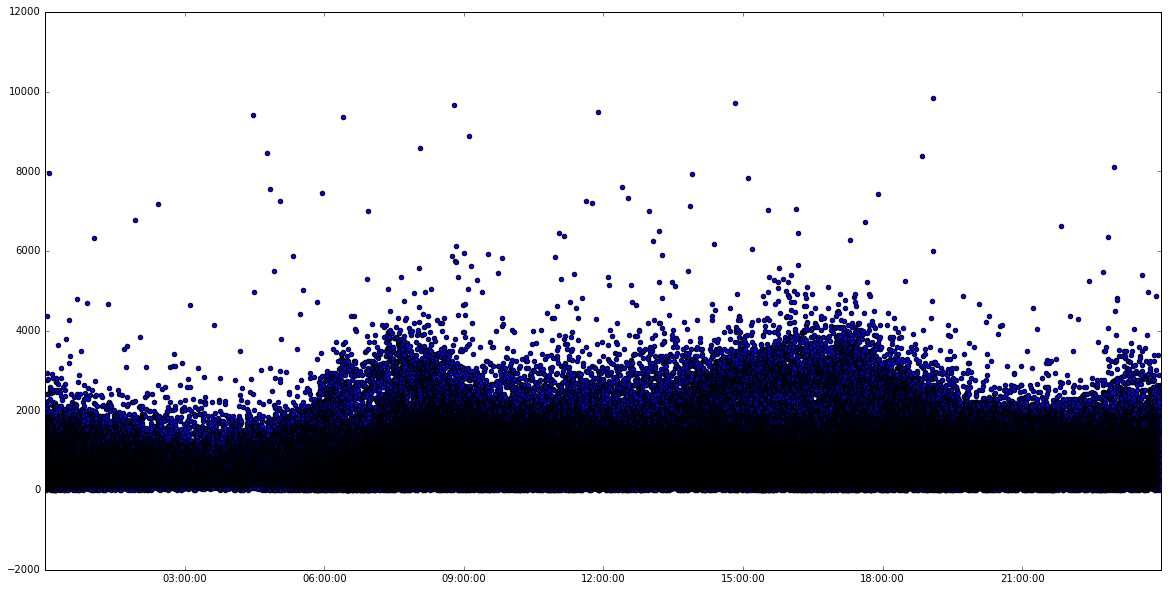

In [40]:
plt.figure(figsize=(20,10))
ax = plt.scatter(oneday.pickup_datetime.values, oneday.trip_time_in_secs.values)
plt.xlim(oneday.pickup_datetime.values.min(), oneday.pickup_datetime.values.max())

(734875.0000115741, 734875.9992939815)

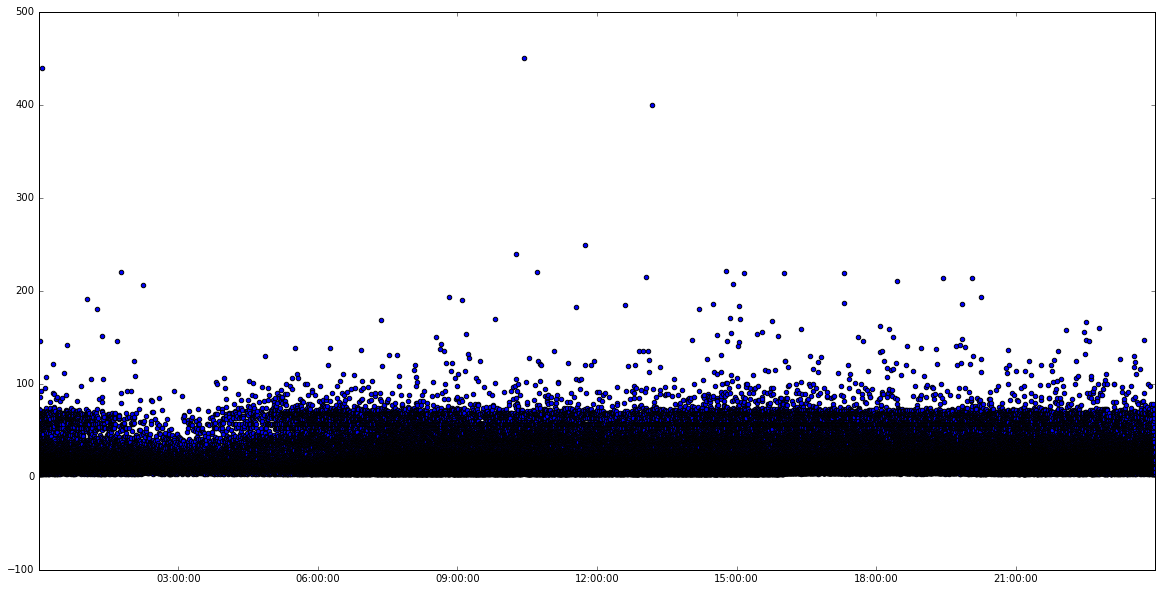

In [41]:
plt.figure(figsize=(20,10))
ax = plt.scatter(oneday.pickup_datetime.values, oneday.total_amount.values)
plt.xlim(oneday.pickup_datetime.values.min(), oneday.pickup_datetime.values.max())